## Racetrack (Exersice 5.12)

The state space and action space and rewards are

\begin{align}
S &= \{ (x,y,v_x, v_y) \quad | \quad (x,y) \in \text{track}, 0 \leq v_{x,y} \leq 4 \} \\
{\cal A}(s = (x,y,v_x, v_y)) &= \{ (a_x, a_y) \quad | \quad a_{x,y} = 0, \pm 1 \text{ and } v_{x,y} + a_{x,y} \in S \} \\
R &= -1 \quad \text{at each step}
\end{align}

Total velocity is zero $(v_x, v_y) = (0,0)$ only at the start line.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from tqdm.notebook import tqdm

## Track shapes

First, let's build the tracks

In [2]:
GRAVEL = -1
ROAD = 0
START = 1
FINISH = 2

def build_track_1():

    track = GRAVEL * np.ones((32,17))

    track[0, 3:] = ROAD
    track[1:3, 2:] = ROAD
    track[3, 1:] = ROAD
    track[4:6, :] = ROAD
    track[6, :10] = ROAD
    track[7:14, :9] = ROAD
    track[14:22, 1:9] = ROAD
    track[22:29, 2:9] = ROAD
    track[29:, 3:9] = ROAD

    track[-1, 3:9] = START
    track[:6, -1] = FINISH

    return track


def build_track_2():

    track = GRAVEL * np.ones((30,32))

    track[0, 16:] = ROAD
    track[1, 13:] = ROAD
    track[2, 12:] = ROAD
    track[3:7, 11:] = ROAD
    track[7, 12:] = ROAD
    track[8, 13:] = ROAD
    track[9, 14:-2] = ROAD
    track[10, 14:-5] = ROAD
    track[11, 14:-6] = ROAD
    track[12, 14:-8] = ROAD

    for i in range(15):
        track[13+i, 14-i:-9] = ROAD

    track[-2:, :-9] = ROAD

    track[-1, :-9] = START
    track[:9, -1] = FINISH

    return track

def build_track():
    return build_track_1(), build_track_2()

In [126]:
track_1, track_2 = build_track()

In [127]:
# Save track shapes 

with open('track_1.npy', 'wb') as f:
    np.save(f, track_1)

with open('track_2.npy', 'wb') as f:
    np.save(f, track_2)

In [92]:
with open('track_1.npy', 'rb') as f:
    track_1 = np.load(f)
with open('track_2.npy', 'rb') as f:
    track_2 = np.load(f)

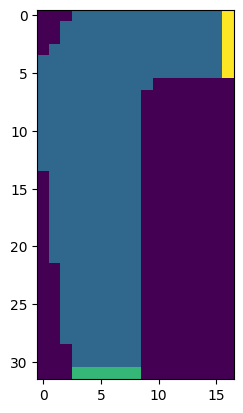

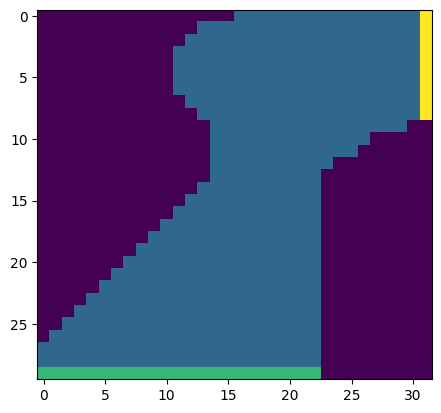

In [249]:
plt.imshow(track_1)
plt.show()
plt.imshow(track_2)
plt.show()

## Environment

In [254]:
class RaceTrack(Env):

    # Values in ndarray self.track below for corresponding parts of the track
    GRAVEL = -1
    ROAD = 0
    START = 1
    FINISH = 2

    REWARD = -1
    
    # Speed limits: V_LOWER < v_{x,y} < V_UPPER
    V_LOWER = 0
    V_UPPER = 5

    CAR = 5
    

    def __init__(self, track, Q_ave, Q_sigma):
        
        self.track = track
        
        self.start_idx = np.array(np.where(self.track == self.START)) # (2, s) shape; s - number of start positions. Each column is (x,y) coord of a start position.
        self.finish_idx = np.array(np.where(self.track == self.FINISH)) # (2, f) shape: same for finish
        
        self.s = self.start_idx.shape[1]  # len of start line
        self.f = self.finish_idx.shape[1] # len of finish line
        
        # Current state
        self.state = None # tuple (x,y,vx,vy)

        # Shape of state space S
        self.nS = self.track.shape + (5,5) 

        # Action space (accelerations)
        self.A = np.array([[ax,ay] for ay in range(-1,2) for ax in range(-1,2)]) # shape (9,2); 9 available actions
        self.nA = (self.A.shape[0],) # = (9,)

        # Precompute allowed actions and accelerations for given velocities (vx,vy)
        self.allowed_accelerations = {(vx,vy): self.get_allowed_accelerations((0,0,vx,vy)) for vy in range(0,5) for vx in range(0,5)}
        self.allowed_actions = {(vx,vy): self.get_allowed_actions((0,0,vx,vy)) for vy in range(0,5) for vx in range(0,5)}

        # Init state-action value Q(s,a) and corresponding greedy policy
        self.Q = self._init_Q(Q_ave, Q_sigma) # State-action value Q(s,a), shape self.nS + (5,5) + (9,)
        self.pi = np.argmax(self.Q, axis=-1)
    
        self.terminated = False
    
    

    def _init_Q(self, Q_ave = 0, sigma = 1):
        '''
        Init estimated state-action value function Q(s,a)
        Shape - track.shape + (5,5) + (9,)
        Unallowed states are masked by float('-inf)
        '''
        QA_shape = self.nS + (9,)
        Q = Q_ave + sigma * np.random.randn(*QA_shape) # shape

        # Mask unallowed accelerations that take velocity out of bounds. 
        # For example, if vx = 1, vy = 0, then accelerations ax = -1, ay = 0 are not allowed.
        for vx in range(5):
            for vy in range(5):
                allowed_actions = self.allowed_actions[(vx,vy)]

                for action in range(9):
                    if action not in allowed_actions:
                        Q[:,:,vx,vy,action] = float('-inf')

        return Q

    
    def reset(self):
        start = np.random.randint(0, self.s)
        x,y = self.start_idx[:, start]
        self.state = (x,y,0,0)


    
    def get_allowed_accelerations(self, state):
        """
        Think of vx,vy as a (5,5) table. 
        The allowed transitions are by -1,0,1 for both vx and vy, except when final velocity is outside the table or is (0,0).
        """
        allowed_accel = []

        x,y,vx,vy = state

        for ax in range(-1,2):
            for ay in range(-1,2):
                vx_new, vy_new = vx + ax, vy + ay

                if (vx,vy, vx_new, vy_new) == (0,0, 0, 1):
                    continue

                if (vx_new, vy_new) != (0,0) and 0 <= vx_new < 5 and 0 <= vy_new < 5:
                    allowed_accel.append([ax,ay])
        
        return np.array(allowed_accel)
    

    def get_allowed_actions(self, state):
        allowed_actions = []

        x,y,vx,vy = state
        
        for ax, ay in self.allowed_accelerations[(vx,vy)]:

            matches = np.all(self.A == np.array([ax, ay]), axis = 1)
            allowed_actions.append(np.where(matches)[0][0])
        
        return np.array(allowed_actions)

    
    def step(self, action, accel_malfunction = False):
        '''
        action - int in range(9)
        '''
        terminated = False

        x,y,vx,vy = self.state
        ax,ay = self.A[action]

        if accel_malfunction == True:
            p = np.random.rand()
            if p <= 0.1:
                ax, ay = 0, 0

        vx_new = vx + ax
        vy_new = vy + ay

        x_new = x - vx_new  # Minus sign because moving up in the track, opposite to x coord.
        y_new = y + vy_new

        next_state = (x_new, y_new, vx_new, vy_new)

        ran_out_of_track, terminated, finish_point = self._check_in_track(self.state, next_state)

        if ran_out_of_track:
            self.reset()
        
        elif not terminated:
            self.state = next_state
        
        elif terminated:
            self.state = finish_point + (vx_new, vy_new)


        return terminated
    
        

    def behavior_policy(self, target_policy, state, eps):
        '''
        Computes behavior policy for a particular state.
        Out - eps-soft policy related to target_policy:
        b(a|s) = 1-eps + eps/nA if a = a^* else eps/nA
        Also outputs behavior policy probability for the chosen action. This is needed to compute importance sampling ratios.
        '''
        p = np.random.rand()
        
        x,y,vx,vy = state

        allowed_actions = self.allowed_actions[(vx,vy)]
        nA = len(allowed_actions)
        
        if p > eps:
            action = target_policy[state]
            b_a = 1-eps + eps/nA
        
        else:
            action = np.random.choice(allowed_actions)
            b_a = eps/nA

        return action, b_a



    def generate_episode(self, eps, accel_malfunction = False):
        '''
        Generate episode using behavior eps-soft policy
        Out - [(R_0, S_0, A_0, b_0), ... , (R_{T-1}, S_{T-1}, A_{T-1}, b_{T-1}), (R_T, S_T, None, None)] 
        S_T - terminal state, b_i probability of action A_i.
        '''

        self.reset()

        terminated = False
        reward = 0

        episode = []

        while not terminated:

            # Choose action
            action, b_a = self.behavior_policy(self.pi, self.state, eps)

            # Log
            episode.append((reward, self.state, action, b_a))

            # transition to next state
            reward -= 1
            terminated = self.step(action, accel_malfunction)

        
        # Log final reward and terminating state
        episode.append((reward, self.state, None, None))
            
        return episode


    def generate_target_policy_episode(self):
        '''
        Generate episode using target policy
        Out - [(R_0, S_0, A_0), ... , (R_{T-1}, S_{T-1}, A_{T-1}), (R_T, S_T, None)] 
        S_T - terminal state
        '''

        self.reset()

        terminated = False
        reward = 0

        episode = []

  
        while not terminated:

            action = self.pi[self.state]
            episode.append((reward, self.state, action))

            # transition to next state
            reward -= 1

            terminated = self.step(action)

            
        episode.append((reward, self.state, None))
            
        return episode


    
    def MC_off_policy(self, n_episodes, eps = 0.1, accel_malfunction = False):
        
        # Init sum of importance sampling ratios C(s,a)
        C = np.zeros(self.nS + self.nA)

        rewards = []

        for _ in tqdm(range(n_episodes)):

            episode = self.generate_episode(eps, accel_malfunction) # 0, ..., T
            rewards.append(episode[-1][0])

            G = 0
            W = 1

            for t in reversed(range(len(episode) - 1)):
                reward, state, action ,b_a = episode[t]
                reward_next = episode[t+1][0]

                G = G + reward_next
                
                q_a = state + (action,)
                
                C[q_a] += W
                self.Q[q_a] += W * (G - self.Q[q_a]) / C[q_a] 
                self.pi[state] = np.argmax(self.Q[state])

                # Exit inner loop and go to next episode, if action a_id in current episode has zero prob under target policy self.pi
                if action != self.pi[state]:
                    break

                W /= b_a
        
        return rewards



    def render(self, episode):
        
        path = self.track.copy()

        for step in episode:
            state = step[1][:2]
            path[state] = self.CAR

        plt.imshow(path)
        plt.show()

    
########################################################################################
    

    def _check_in_track(self, state_0, state_1):

        # assume x0 >= x1, y0 <= y1; x-axis up to down, y-axis left to right; consistent with matrix indices
        
        traj = RaceTrack.get_trajectory(state_0, state_1)

        ran_out_of_track = False
        finished = False

        for x,y in traj:

            if not (0 <= x < self.track.shape[0] and 0 <= y < self.track.shape[1]):
                ran_out_of_track = True
                return ran_out_of_track, finished, None
        
            elif self.track[x,y] == self.GRAVEL:
                ran_out_of_track = True
                return ran_out_of_track, finished, None
            
            elif self.track[x,y] == self.FINISH:
                finished = True
                finish_point = (x,y)
                return ran_out_of_track, finished, finish_point
                 
        return ran_out_of_track, finished, None
    




    @staticmethod
    def get_trajectory(state_0, state_1):
        '''
        Same as _get_trajectory, but coordinates now correspond to array indices and states:
        -------> y
        |
        |
        |
        v
        x

        Assume x0 >= x1, y0 <= y1
        '''
        x0,y0,_,_ = state_0
        x1,y1,_,_ = state_1

        dx = x0 - x1
        dy = y1 - y0
        
        error = 0
        traj = [(x0,y0)]

        # For slope <= 1
        #print(x0, x1)
        if dx <= dy:
        
            x_curr = x0
            for y in range(y0+1, y1+1):
                error += 2*dx

                if error >= dy:
                    x_curr -= 1
                    error -= 2*dy
                
                traj.append((x_curr,y))

            
        else:
            y_curr = y0
            for x in range(x0-1, x1-1, -1):
                error += 2*dy

                if error >= dx:
                    y_curr += 1
                    error -= 2*dx
                
                traj.append((x,y_curr))
            
        return traj
    



########################################################################################

    # The following is not needed for the current problem. It is Bresenham's algorithm with standard orientation of coordinates.


    @staticmethod
    def _get_trajectory(x0,y0,x1,y1):
        
        '''
        Compute trajectory of pixels from (x0,y0) to (x1,y1) using Bresenham's line algorithm.
        
        Assumes x0<x1, y0<y1. 

        Note that coordinates x,y here are with x pointing right and y pointing up:
        
        y
        ^
        |
        |
        |
        --------> x

        unlike the coordinates used for indexing arrays and states. 

        For slope < 1:
        Init y_curr = y0, error = 0
        Iterate over x in range(x0, x1+1)
        Update error += slope
        If error >= 1/2, then y_curr + 1 is closer to the line. Therefore update y_curr += 1 and error -= 1.

        Rescale everything by 2*(x1-x0) to use integer arithmetic.
        '''

        dx = x1 - x0
        dy = y1 - y0
        
        error = 0
        traj = [(x0,y0)]

        # For slope <= 1
        if dy <= dx:
            
            y_curr = y0
            for x in range(x0+1, x1+1):
                error += 2*dy

                if error >= dx:
                    y_curr += 1
                    error -= 2*dx
                
                traj.append((x,y_curr))
        else:
            
            x_curr = x0
            for y in range(y0+1, y1+1):
                error += 2*dx

                if error >= dy:
                    x_curr += 1
                    error -= 2*dy
                
                traj.append((x_curr,y))

        return traj






# Monte-Carlo training, track 1

Initialize the enivronement. We choose Q_ave = -50000 for the average state-action value. It is important to choose a sufficiently negative value. With small Q_ave training is excruciatingly slow.

The explanation of this is presumably that if we assume small values of Q, then it is difficult to distinguish good policy from the initialization noise. While if we take very negtive initial values, then whenever we stumble on actions with bigger reward, the algorithm quickly learns that some actions are much better then others.

In [212]:
race = RaceTrack(track_1, Q_ave = -500000, Q_sigma = 1)

In [ ]:
rewards = race.MC_off_policy(1000000, eps = 0.1)

Rewards near the end of training are reasonably small

In [216]:
rewards[-10:]

[-11, -24, -21, -13, -19, -12, -11, -26, -20, -39]

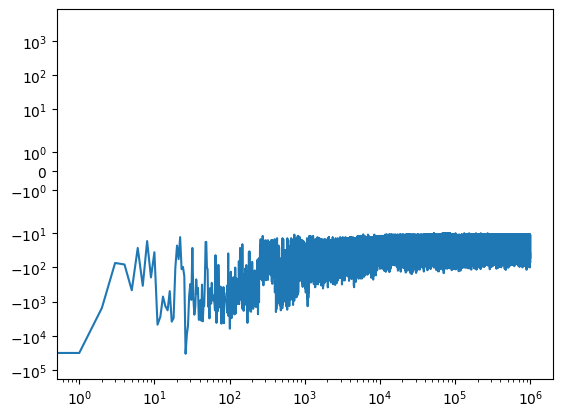

In [277]:
plt.plot(list(range(len(rewards))), rewards)
plt.xscale('log')
plt.yscale('symlog')
plt.show()

Sample episodes generated with the trained deterministic target policy

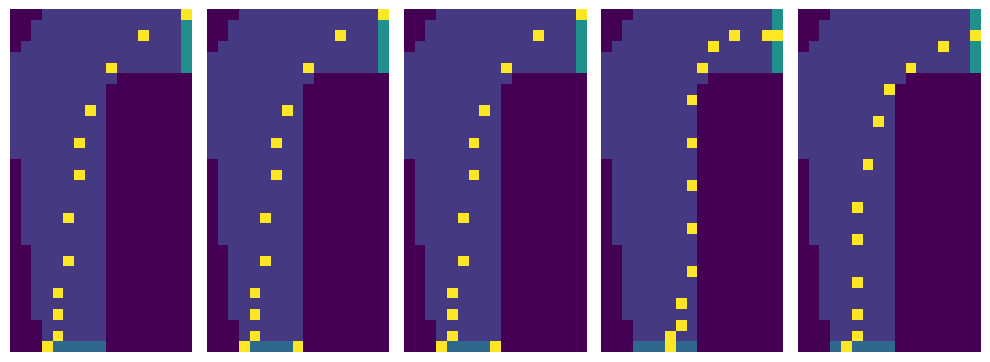

In [243]:
CAR = 5
n_ep = 5

plt.figure(figsize=(10, 5)) 

for i in range(1,n_ep+1):
    ep = race.generate_target_policy_episode()
    path = track_1.copy()
    for step in ep:
        state = step[1][:2]
        path[state] = CAR
    
    plt.subplot(1, n_ep, i)  # 1 row, N columns, ith subplot
    
    plt.imshow(path)
    plt.axis('off')  
    
plt.tight_layout()  
plt.show()


## Acceleration malfunction

With probability 0.1 both accelerations are zero, independent of the intended acceleration chosen by the behavior policy. Target policy works as before.

In [255]:
race_mal = RaceTrack(track_1, Q_ave = -500000, Q_sigma = 1)

In [ ]:
rewards_mal = race_mal.MC_off_policy(1000000, eps = 0.1, accel_malfunction = True)

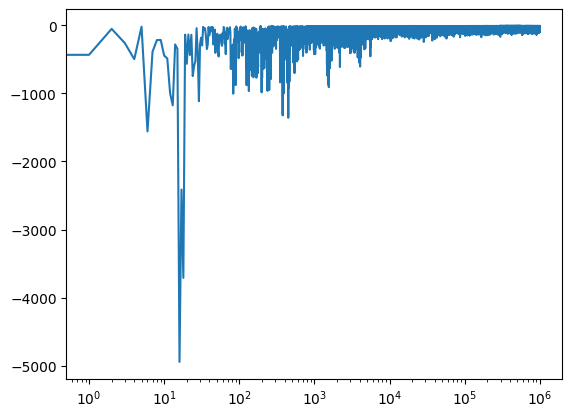

In [273]:
plt.plot(list(range(len(rewards_mal))), rewards_mal)
plt.xscale('log')
# plt.yscale('symlog')
plt.show()

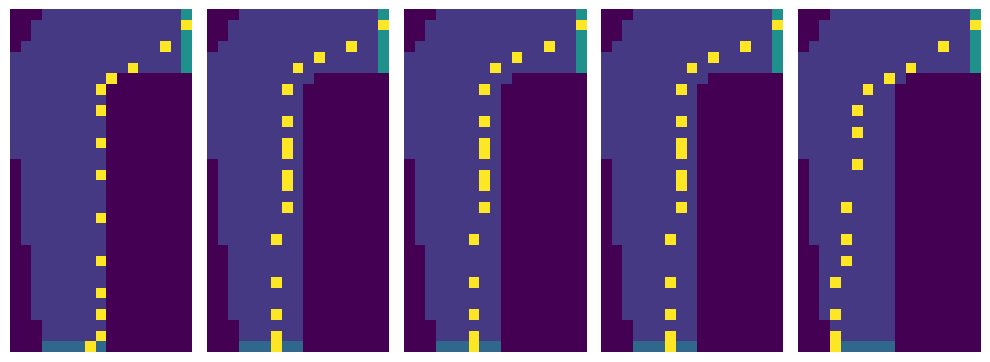

In [260]:
CAR = 5
n_ep = 5

plt.figure(figsize=(10, 5)) 

for i in range(1,n_ep+1):
    ep = race_mal.generate_target_policy_episode()
    path = track_1.copy()
    for step in ep:
        state = step[1][:2]
        path[state] = CAR
    
    plt.subplot(1, n_ep, i)  # 1 row, N columns, ith subplot
    
    plt.imshow(path)
    plt.axis('off')  
    
plt.tight_layout()  
plt.show()

# Monte-Carlo, track 2

In [229]:
race_2 = RaceTrack(track_2, Q_ave = -500, Q_sigma = 1)

In [ ]:
rewards_2 = race_2.MC_off_policy(1000000, eps = 0.1)

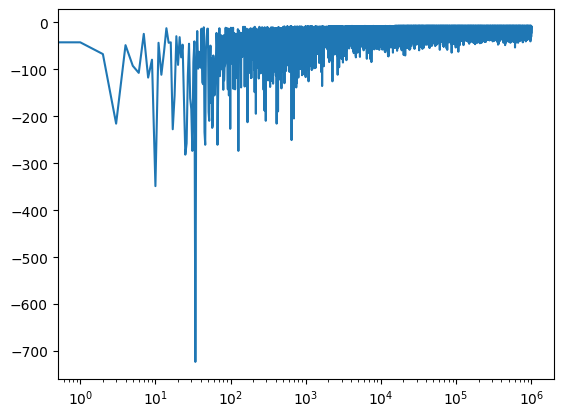

In [274]:
plt.plot(list(range(len(rewards_2))), rewards_2)
plt.xscale('log')
# plt.yscale('symlog')
plt.show()

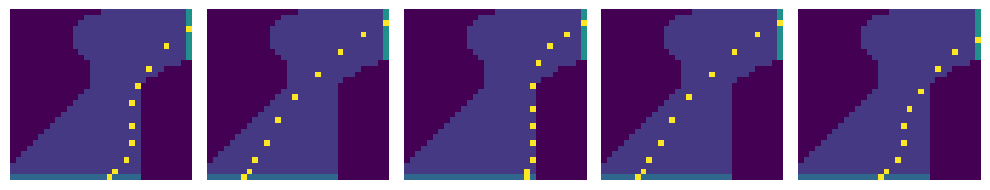

In [244]:
CAR = 5
n_ep = 5

plt.figure(figsize=(10, 5)) 

for i in range(1,n_ep+1):
    ep = race_2.generate_target_policy_episode()
    path = track_2.copy()
    for step in ep:
        state = step[1][:2]
        path[state] = CAR
    
    plt.subplot(1, n_ep, i)  # 1 row, N columns, ith subplot
    
    plt.imshow(path)
    plt.axis('off')  
    
plt.tight_layout()  
plt.show()

## Acceleration malfunction

In [261]:
race_mal_2 = RaceTrack(track_2, Q_ave = -500, Q_sigma = 1)

In [ ]:
rewards_mal_2 = race_mal_2.MC_off_policy(1000000, eps = 0.1, accel_malfunction = True)

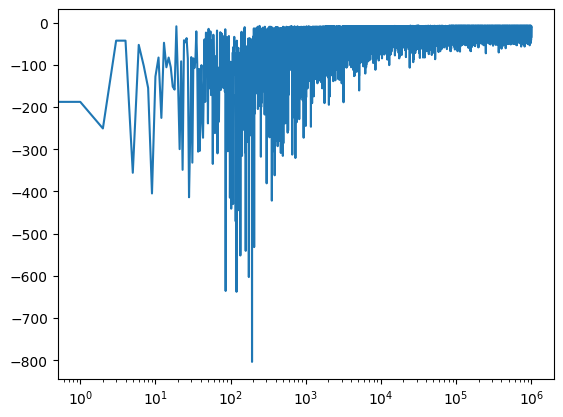

In [275]:
plt.plot(list(range(len(rewards_mal_2))), rewards_mal_2)
plt.xscale('log')
# plt.yscale('symlog')
plt.show()

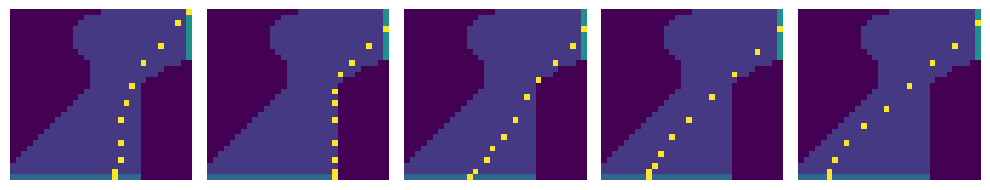

In [267]:
CAR = 5
n_ep = 5

plt.figure(figsize=(10, 5)) 

for i in range(1,n_ep+1):
    ep = race_mal_2.generate_target_policy_episode()
    path = track_2.copy()
    for step in ep:
        state = step[1][:2]
        path[state] = CAR
    
    plt.subplot(1, n_ep, i)  # 1 row, N columns, ith subplot
    
    plt.imshow(path)
    plt.axis('off')  
    
plt.tight_layout()  
plt.show()